# autotab

`autotab` is an attempt to create tablatures from a scan of a music score. The goal of this notebook is to give some kind of insight on entire processing pipeline of the project. 

## Problem statement
Given an adequate scan of a music score, detect all relevant glyphs for a tablature generation. 

Tablatures are a music representation for string instruments like guitars. Standard tablatures will not represent the duration of the notes. They will only encode the pitch of the notes with a number on a string. Here is a example of a tablature:

<img src="tablature_example.png" width="500">

Therefore, the glyphs that are relevant to this work are only the ones that affect the pitch (noteheads, accidentals, etc.). In other words, given an scan of a music score, detect all glyphs that affect the pitch of a note. The process of converting them to a tablature representation is trivial.

## Pipeline
In machine learning, to train a classifier, there must be data. For this project, the two dataset of interest are the `deepscores` and `muscima` datasets. The former contains a gigantic amount of computer generated scores along with XML description files for the groundtruth data. The latter contains about 500 scores from different writers along with XML that describes the ground truth.

Before utilizing the datasets, the first step is to formulate all the processing pipeline that would aim to detect every relevant glyph in a score. The reason behind this is that the training processes have to behave as similarly as inference.

Music scores are a kind of natural language. Like in any natural language, there is a hierchichal pattern of representation. In a music score, there are staff lines. In a staff line there are measures. Finally, in measure, there are glyphs. For the purpose of the project, measures are not a concern since they do not affect pitch.

That being said, the first step in the pipeline would be:

**1. Detect all the staff lines in a given score**

Fortunately, this was already done in another project called `staff-detect`. `staff-detect` can detect staffs in distorted images and rectify them the best way possible. For the purpose of this notebook, we will use a straight scan that was computer generated from the `deepscores` dataset. Here is an example of staff line detection.

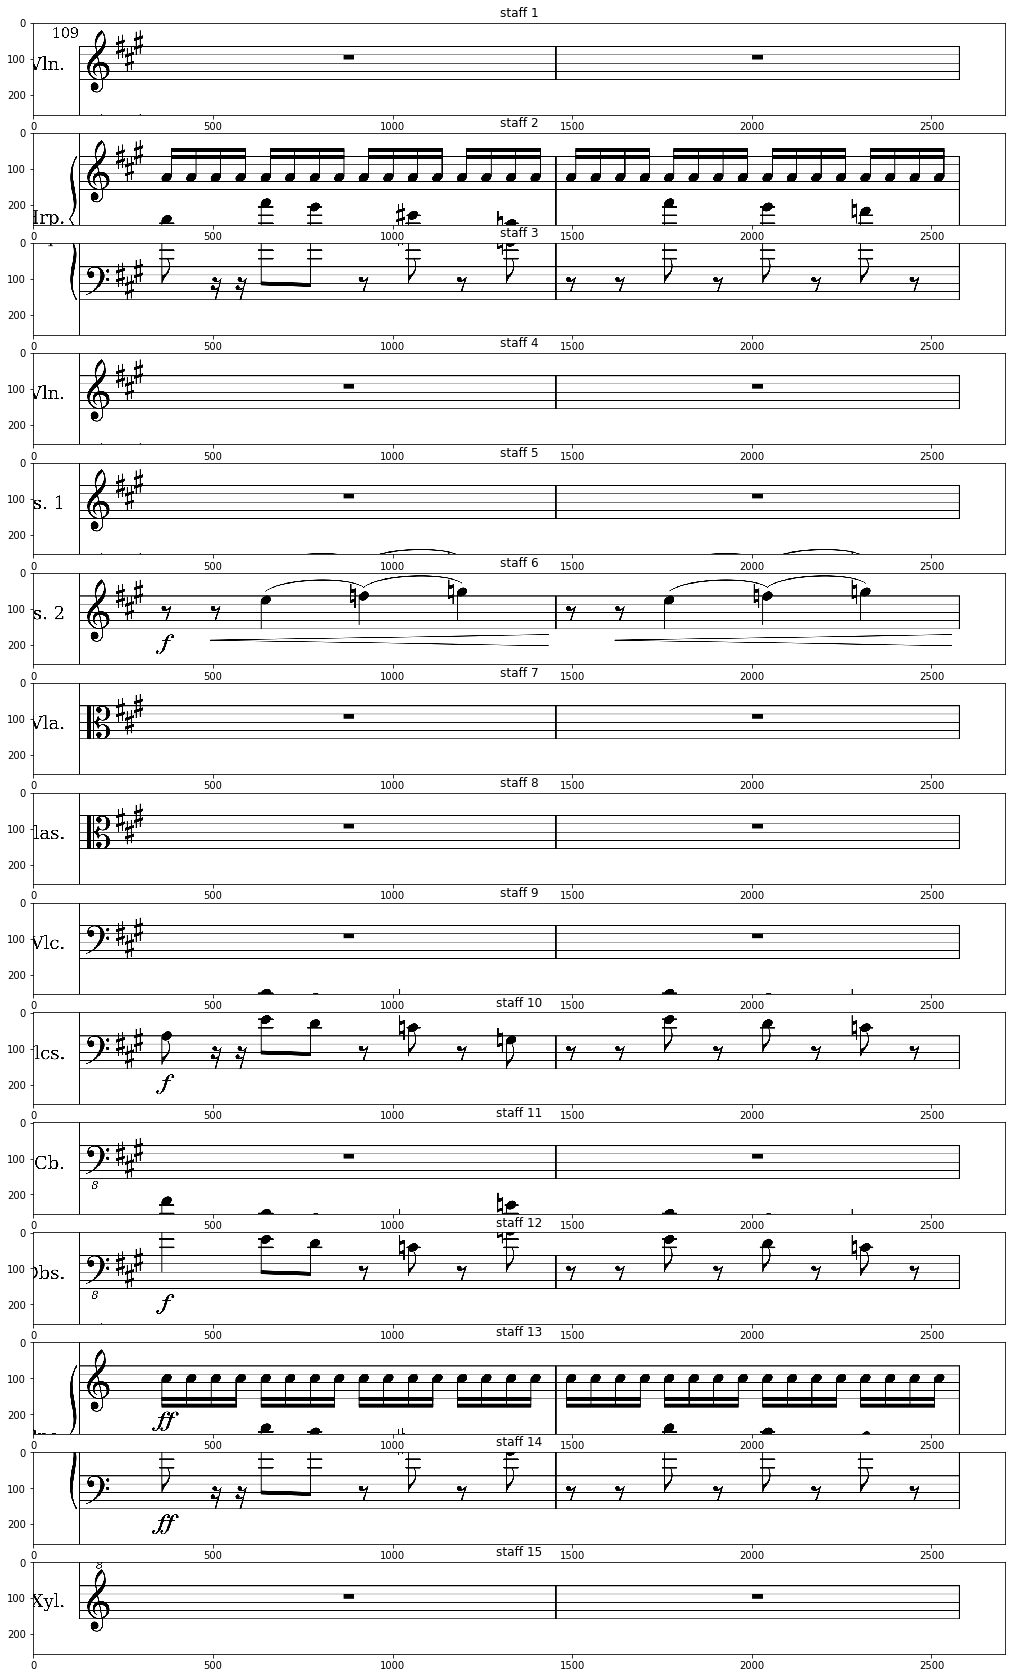

In [1]:
%matplotlib inline

import sys
sys.path.append('../src/')

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from score import Glyph, BBox, Score

# Test file from the deepscores dataset
TEST_IMAGE_FN = '../data/deepscores/lg-7630010-aug-beethoven--page-35.png'
# Staff line detection description file in XML
TEST_XML_FN = '../data/stav_output/lg-7630010-aug-beethoven--page-35.xml'
img = cv.imread(TEST_IMAGE_FN, 0)
score = Score(TEST_XML_FN)

fig, ax = plt.subplots(len(score), 1, figsize=(30,30))
for i, staff in enumerate(score):
    staff_image = score.extract_staff_image(img, staff)
    ax[i].imshow(staff_image, cmap='gray')
    ax[i].set_title('staff {}'.format(i + 1))

Once a staff is detected, the process glyph detection will be independant from other staffs. This step will be done on both datasets. Even if the datasets themselves contain ground truth for staff lines too, it is deemed more adequate to use the process that would be used during inference. The high success rate (over 98%) of the `staff-detect` module means that even if a staff is wrongly positioned, it will not affect the training significantly enough.

The next process in the pipeline would be to 

**2. detect all the glyphs in the staff**.

This is no simple task. Other approaches aim to use modern deep learning methods like Mask RCNN to generalize the feature extraction by which a glyph is classified. Unfortunately, these methods have a terrible performance for OCR (or OMR in this case) and they require tremendous amounts of computational power. In the next section, the process by which a glyph is extracted will be explained.

## Glyph extraction
**A note on staffs**

Straight staffs can be described by three parameters:
1. $S$, staff space : Distance in pixels between each staff line.
2. $H$, staff height : Thickness in pixels of a line.
3. $e$, extra staff lines : The amount of staff lines above and under a staff that are not drawn.

Since each staff will have five staff lines and, once can expect a staff to be as thick as 

$S_t = S \cdot (4 + 2 \cdot e) + H \cdot (5 + 2 \cdot e)$

These parameters describe every staff in a score. They are common to every single staff. This is the only assumption made, that is that every staff in a score should behave like the others. Lines should be parallel and parameters should be equal. If those requirements are not meant, it is impossible to do any kind of staff line detection. This is where more computer vision methods will fail and it is judged reasonable to require it.

**End of note**

Let's first have a close look at a spicific staff line. Let's pick the 12th (11th index) staff line from the example score. Music notation has strong patterns in its representation. First, of all, between each glyph, there is a spacing.  That spacing denotes the absence of a glyph. To illustre this, let's plot the number of black pixels in every column of the staff 12.

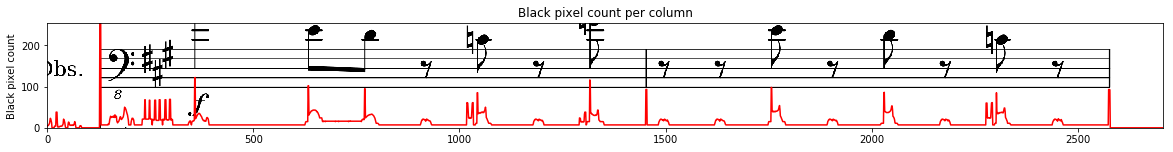

In [2]:
example_staff = score[11]
example_staff_image = score.extract_staff_image(img, example_staff)
col_count = np.count_nonzero(example_staff_image == 0, axis=0)

plt.figure(figsize=(20,20))
rows, cols = example_staff_image.shape
plt.imshow(example_staff_image, extent=[0, cols, 0, rows], cmap='gray')

plt.plot(col_count, 'r-')
plt.title('Black pixel count per column');
plt.ylabel('Black pixel count');

In the preceding plot, the columns where a glyph is present contain more black pixels than the empty ones. Before feeding every single region of interest in a staff to a neural network, one could filter all the regions that do not contain a glyph. A first horizontal sweep of the staff like previously done could hint at sections of the staff that may contain glyphs.

The threshold of glyph detection will be
$T = 7 \cdot H$

The rationale behind this value is that whenever a glyph is existent, it will vastly surpass the cumulative amount of staff height over one staff. Putting $T$ at $5 \cdot H$ would result in many false positives. Here is a plot of the threshold detection:

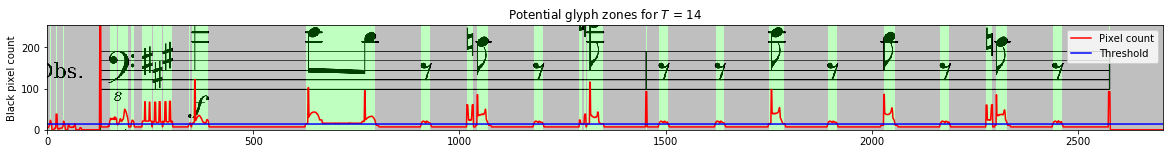

In [4]:
GREEN_MASK = (0,255,0) # -Jim Carrey

T = score.step_threshold
# Converting the grayscale image into an rgb image
rgb_staff_image = np.stack((example_staff_image,) * 3, axis=-1)
# Getting all zones where there might be a glyph
zone_bboxes = score.potential_glyphs(example_staff_image)

# Coloring the zones in green
mask_image = np.zeros(rgb_staff_image.shape)
for (xmin, xmax, ymin, ymax) in zone_bboxes:
    mask_image[ymin:ymax, xmin:xmax] = GREEN_MASK
alpha = 0.25
rgb_staff_image = rgb_staff_image * (1-alpha) + mask_image * alpha
rgb_staff_image = rgb_staff_image.astype('int')

# Plotting everything
plt.figure(figsize=(20,20))
plt.imshow(rgb_staff_image, extent=[0, cols, 0, rows], cmap='gray')
plt.plot(col_count, 'r-')
plt.plot([T] * cols, 'b')

plt.title('Potential glyph zones for $T$ = {}'.format(T))
plt.ylabel('Black pixel count');
plt.legend(['Pixel count', 'Threshold']);

Notice how a simple naïve thresholding managed to filter most of the pixels in the image. The next step is to move a small box of size $c$ x $c$ around all the potential zones in the image and to threshold over the amount of black pixels in that box.

The threshold, $B$, would be defined as
$B = c \cdot H \cdot 2$.

Whenever a roi would exceed that threshold, it would mean there is a potential glyph. There are going to be a lot of duplicates and false positives but training a neural network to ignore those is going to be a simple task. Here are the results.

In [ ]:
GREEN_MASK = (0,255,0) # -Jim Carrey

B = score.kernel_threshold
rgb_staff_image = np.stack((example_staff_image,) * 3, axis=-1)

# Coloring the zones in green
mask_image = np.zeros(rgb_staff_image.shape)
for (xmin, xmax, ymin, ymax) in zone_bboxes:
    mask_image[ymin:ymax, xmin:xmax] = GREEN_MASK
alpha = 0.25
rgb_staff_image = rgb_staff_image * (1-alpha) + mask_image * alpha
rgb_staff_image = rgb_staff_image.astype('int')

# Plotting everything
plt.figure(figsize=(20,20))
plt.imshow(rgb_staff_image, extent=[0, cols, 0, rows], cmap='gray')
plt.plot(col_count, 'r-')
plt.plot([T] * cols, 'b')

plt.title('Potential glyph zones for $T$ = {}'.format(T))
plt.ylabel('Black pixel count');
plt.legend(['Pixel count', 'Threshold']);